# 2 Model Selection & Training

The machine learning algorithm I have chosen for my Image Classification task is called Convolutional Neural Network (CNN). This algorithm allows the model to understand the features of the image with foresigh and remember the features in order to guess the class of image.

### 2.1 What is a Convolutional Neural Network?

They are similiar to normal neural networks like we discused in class expect that they are designed for an input of grid-like data or images. CNN's also automatically learn hierachical features from the input image through their layers. Another important feature is *weight sharing*, CNN's apply the same filter across different parts of an image reducing the parameters and making the model more efficient. I chose CNN because of it's strong performance with image classification.

They are made up of 3 main types of layers:

1. Convolutional Layer
  - core building block, does most of the computational heavy lifting
  - a series of learnable filters that slide across the image and perform element-wise mutliplications and summations to produce feature maps
2. Pooling Layer
  - reduce the spatial deminsions of the feature maps
  - reduce the amount of paramaeters and computation in the network -> control overfitting
  - makes the network less sensitive to minor variations in the input
3. Fully Connected Layer
  - connect all neurons in one layer to all neurons in the next layer
  - used to learn complex relationships between features and make predictions

These layers are stacked to form a full ConvNet architecture.

For more information:

https://cs231n.github.io/convolutional-networks/  


https://www.geeksforgeeks.org/image-classifier-using-cnn/


### 2.2 Implementing Convolutional Neural Network

The ConvNet architecture layering pattern I have chosen is `INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC`. It is made up of two CONV (convolutional) layers stacked before every pool layer. This is because CONV layers can help to develop more complex features. In total we have 3 blocks of CONV POOl layers and we end with the FC (fully connected) layers.

I chose ReLU (Rectified Linear Unit) for my neural network for a few reasons.
1. It is non-linear : needed for neural networks to learn complex patterns in data
  - allows the network to approximate a wide range of functions and solve more complex problems (like image classification)
2. Efficiency : faster than activation functions like sigmoid or tanh (Especially for image classification!)
3. Sparsity : since this activation function outputs 0 for negative inputs, this introduces sparcity in the networks activations leading to better generalization and preventing overfitting

In [29]:
model = tf.keras.models.Sequential([
    # Input layer (Assuming input shape is (img_size, img_size, 3))
    tf.keras.layers.Input(shape=(img_size, img_size, 3)),

    # Data Augmentation Layer (created in `Data Exploration`)
    data_augmentation,

    # Normilization Layer (created in `Data Exploration`)
    normalization_layer,

    # [CONV -> RELU -> CONV -> RELU -> POOL]*3 block
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        # padding='same' : ensures the output size is the same as the input size
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Adding Dropout to Convolutional Layers
    tf.keras.layers.Dropout(0.15),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Adding Dropout to Convolutional Layers
    tf.keras.layers.Dropout(0.15),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # [FC -> RELU]*2 block
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.25), # Adding L2 Regularization and Dropout to Dense Layers

    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.25), # Adding L2 Regularization and Dropout to Dense Layers

    # Final FC layer (Output layer)
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


---
As seen above there are comments that say `Adding Dropout` or `Adding L2 Regularization`, this is because in order to try to continue improving my model I implemented regularization techniques.
> **L1 and L2 Regularization** adds penatlty terms to the loss function and discorage large weights in the model. **L1** encourages sparsity and **L2** encourages smaller weights overall.

> **Dropout** randomly sets a fraction of input units to 0 at each update during training in an effort to prevent overfitting by reducing interdependence between neurons.

After one run with this improvement I saw a decrease in performance so I lowered the regularizer from `0.01` to `0.001` and decreased the dropout of the dense layers from `0.5` to `0.25` and the dropout of conv layers from `0.25` to `0.15`. This brought my performance back up and was successful.

---

**Adam Optimizer** : is an adaptive learning rate optimization algorithm - it auto adjusts the learning rate for each parameter during training
1. Efficient - often faster than other optimizers (espicially in deep learning neural networks)
2. Adaptability - can handle sparse gradients and noisy data more effectively
3. Easy of use - less hyperparameter tuning
4. Works well with large datasets
5. Well-suited or deep neural networks

In [30]:
# Compile the model
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy', # Loss function for multi-class classification with integer labels
  metrics=['accuracy']
  )

---
After the first run of my model I noticed there could be potential overfitting due to the training accuracy being slightly higher than the validation accuracy on epochs 5 and 7. In order to work on combating this I decided to implement early stopping.

In [31]:
early_stopping = EarlyStopping(
  monitor='val_loss',        # Metric to monitor (e.g., validation loss)
  patience=3,                # Number of epochs with no improvement before stopping
  restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

---

In [32]:
epochs = 9  # Number of training epochs
history = model.fit(
  train,                      # Training dataset
  verbose=1,                  # Print progress
  validation_data=test,       # Validate with test dataset
  epochs=epochs,
  callbacks=[early_stopping]  # Early stopping to prevent overfitting
)

Epoch 1/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 69s 4s/step - accuracy: 0.5002 - loss: 1.3399 - val_accuracy: 0.9400 - val_loss: 0.9376
Epoch 2/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.7635 - loss: 0.8201 - val_accuracy: 0.8300 - val_loss: 0.5826
Epoch 3/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 79s 4s/step - accuracy: 0.9463 - loss: 0.4077 - val_accuracy: 0.9700 - val_loss: 0.2702
Epoch 4/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.9721 - loss: 0.2573 - val_accuracy: 1.0000 - val_loss: 0.1731
Epoch 5/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.9919 - loss: 0.1812 - val_accuracy: 1.0000 - val_loss: 0.1461
Epoch 6/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 83s 4s/step - accuracy: 0.9907 - loss: 0.1644 - val_accuracy: 1.0000 - val_loss: 0.1292
Epoch 7/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.9967 - loss: 0.1374 - val_accuracy: 1.0000 - val_loss: 0.1165
Epoch 8/9
16/16 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.9819 - loss: 0.1483 - val_accuracy: 0.9900 - val_loss: 0.1317


### 2.3 Model Accuracy and Metrics

The model achieved perfect accuracy `100%`!! This means it correctly classified all the images in the test set. The test loss was `0.0990` which means we have great performance and the model is making confident and accurate predictions.


The model performed exceptionally well on the test dataset! But what would happen with outside data? See the next section `2.4 Outside Data Testing` for more.

In [33]:
# Print out the test accuracy and loss
test_loss, test_acc = model.evaluate(test, verbose=2)
print('\nTest accuracy:', test_acc)
print('Test loss:', test_loss)

4/4 - 3s - 675ms/step - accuracy: 1.0000 - loss: 0.0990

Test accuracy: 1.0
Test loss: 0.0990225225687027


---

To test for overfitting and underfitting I use the code below.
- If the training accurancy is significantly higher than the valdiation accuracy the model is likely overfitting and memorizing the training data.
- If the training and validation accuracy are both low it suggests the model is underfitting, and is not complex enough to learn the patterns in the image data.

In [34]:
# Print training and validation accuracy
print("Training accuracy:", history.history['accuracy'])
print("Validation accuracy:", history.history['val_accuracy'])

Training accuracy: [0.5120000243186951, 0.7919999957084656, 0.9259999990463257, 0.9739999771118164, 0.9879999756813049, 0.9919999837875366, 0.9919999837875366, 0.9739999771118164, 0.9860000014305115]
Validation accuracy: [0.9399999976158142, 0.8299999833106995, 0.9700000286102295, 1.0, 1.0, 1.0, 1.0, 0.9900000095367432, 1.0]


As we can see below, the training accuracy is never significantly higher than the validation accuracy, this means the model is likely not overfitting.

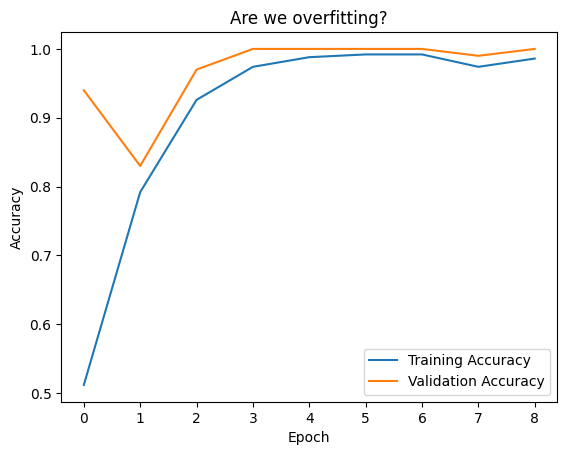

In [35]:
# Testing for overfitting
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Are we overfitting?')
plt.legend()
plt.show()

Since neither the training nor validation accuracy are low we can also rule out underfitting.

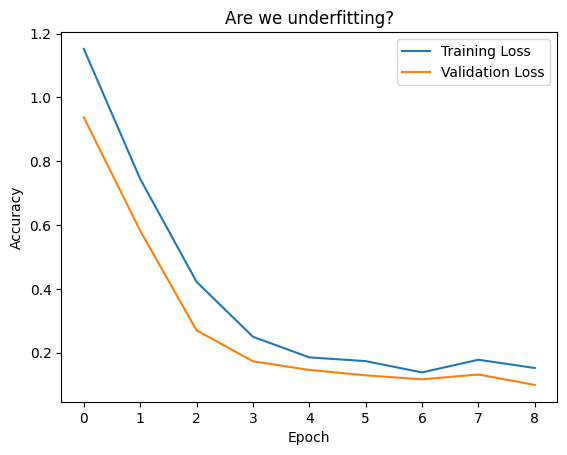

In [36]:
# Testing for underfitting
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Are we underfitting?')
plt.legend()
plt.show()

After applying improvements my models accuracy improved and is more stable with redued overfitting.

---

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Image Prediction 
Actual label:  Bears
Predicted label:  Bears


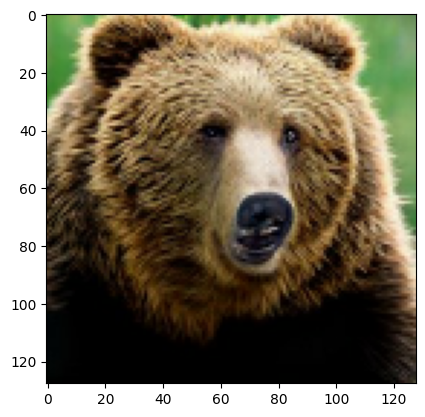

In [37]:
# Choose one image and make a prediction for it
for img_batch, labels_batch in test.take(1):

    first_img = img_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_img)

    batch_prediction = model.predict(img_batch)

    print('Image Prediction ')
    print('Actual label: ', class_names[first_label])
    print('Predicted label: ',class_names[np.argmax(batch_prediction[0])])


Below we can see a visualization of the model's confidence in predicting images. Since the confidence of each image is pretty high the model is making strong predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 884ms/step


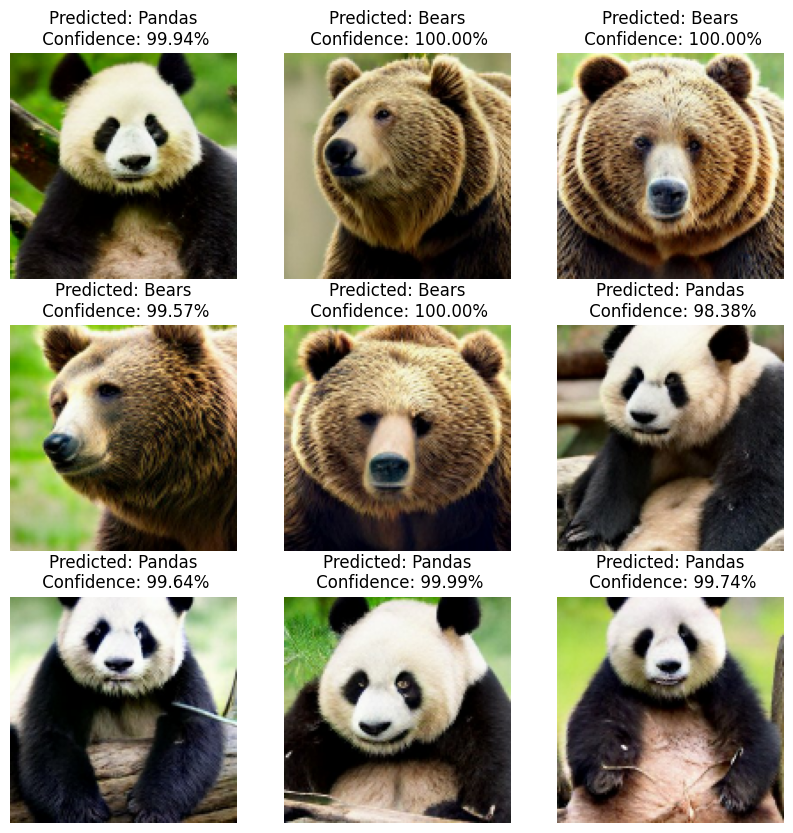

In [40]:
# Assuming 'test' is your test dataset and 'class_names' are defined
for images, labels in test.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    predicted_probabilities = np.max(predictions, axis=1)

    # Display images with predictions and confidence scores
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display the first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        confidence_percentage = predicted_probabilities[i] * 100  # Convert to percentage
        plt.title(f"Predicted: {class_names[predicted_labels[i]]}\n Confidence: {confidence_percentage:.2f}%")
        plt.axis("off")
    plt.show()
    break  # Exit the loop after processing one batch

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 859ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 880ms/step


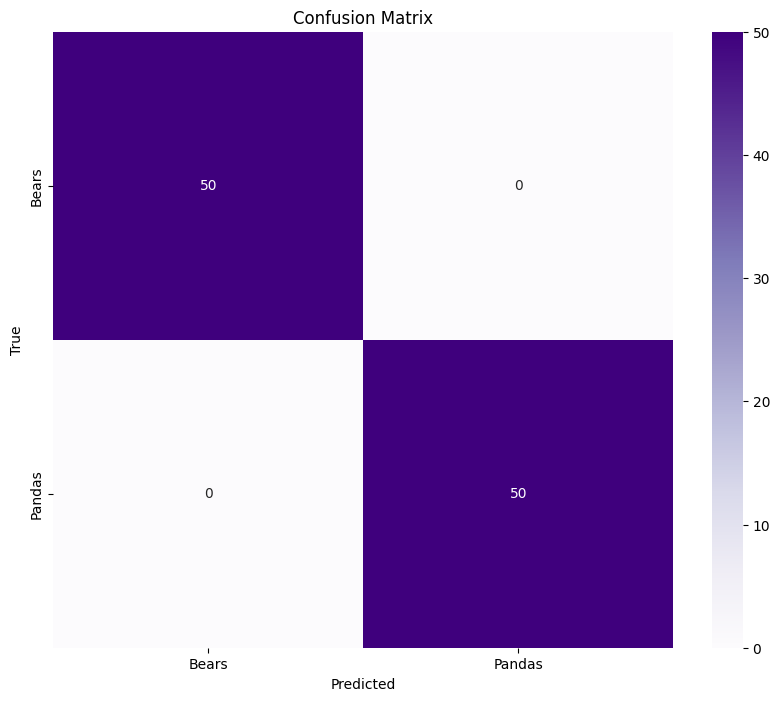

Confusion Matrix:
[[50  0]
 [ 0 50]]


In [41]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []   # Stores the true labels
y_pred = []   # Stores the predicted labels

# Loop through the test dataset
for images, labels in test:
    predictions = model.predict(images)   # Get the predictions
    predicted_labels = np.argmax(predictions, axis=1) # Get the predicted label

    y_true.extend(labels.numpy())  # Add the true labels to the list
    y_pred.extend(predicted_labels)  # Add the predicted labels to the list

# Cacluate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
# Create a heatmap of the confusion matrix:
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
      # annot=True: Display the numbers in the heatmap
      # fmt='d': Format the numbers as integers
      # cmap='Blues': Use the Blues colormap
      # xticklabels and yticklabels: Set the labels for the x and y axes
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print confusion matrix as text
print("Confusion Matrix:")
print(cm)

To evaluate my model I chose to use the F1-score primarly. This is because it is a combination of both precision and recall. I chose this because of the datasets characterisitics (balanced classes and binary classification). However, as we can see below, the model performed well on EVERY metric meaning, our model makes no mistakes classifying bears or pandas and all 100 images were classified correctly.

In [42]:
from sklearn.metrics import classification_report

# Get metrics for model
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       Bears       1.00      1.00      1.00        50
      Pandas       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [43]:
model.save('pandasBears1.keras') # Save the model!!

### 2.4 Outside Data Testing

As we can see below, the model is also **extremely** accurate with images from google. It classified every image correctly with high confidence. This means our model performs well on new, unseen images in real-world scenarios. This is also a strong indicator that the model is not overfit to the training data.

Found 10 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step


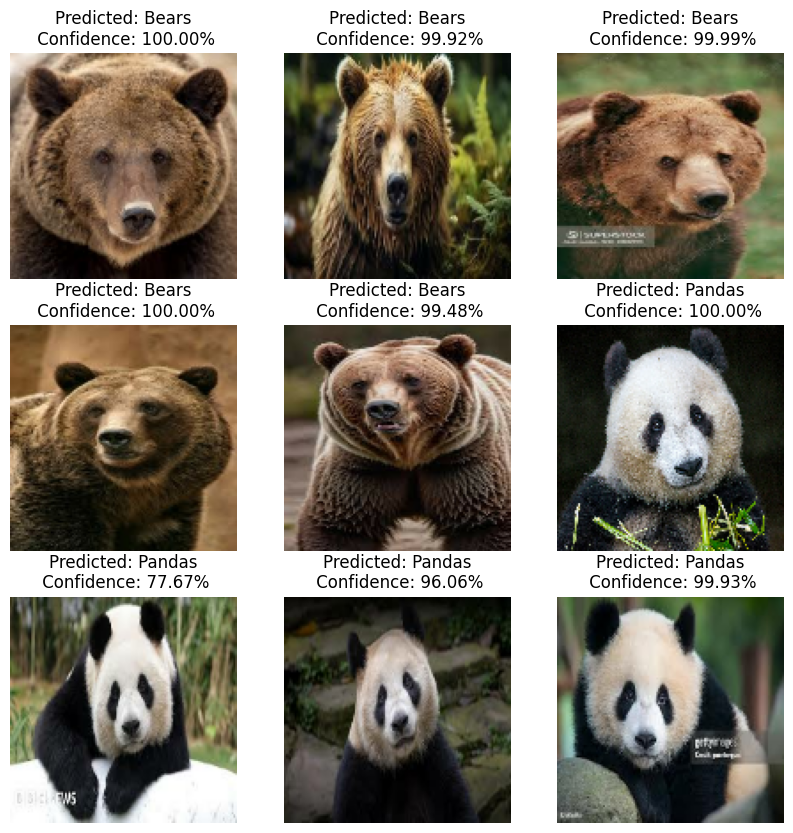

In [44]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load your trained model (not always used)
# model = tf.keras.models.load_model('pandasBears1.keras')

# Define paths to outside dataset folders
outside_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/machine-learning-final/OnlineImages"
bears_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/machine-learning-final/OnlineImages/Bears"
pandas_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/machine-learning-final/OnlineImages/Pandas"

# Create a tf.data.Dataset for the outside dataset
img_size = 128
batch_size = 32

outside_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    outside_dir,
    image_size=(img_size, img_size),
    shuffle=False,  # No need to shuffle for evaluation
    batch_size=batch_size
)

# Make predictions and display images with confidence scores
for images, labels in outside_dataset.take(1): # Takes one batch
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    predicted_probabilities = np.max(predictions, axis=1)

    # Display images with predictions and confidence scores
    plt.figure(figsize=(10, 10))
    for i in range(min(9, len(images))):  # Display up to 9 images, or fewer if batch is smaller
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        confidence_percentage = predicted_probabilities[i] * 100  # Convert to percentage
        predicted_class = class_names[predicted_labels[i]]
        plt.title(f"Predicted: {predicted_class}\n Confidence: {confidence_percentage:.2f}%")
        plt.axis("off")
    plt.show()
    break  # Exit the loop after processing one batch

### 2.5 Model Layer Visualization

I use the summary and plot_model features to show a represntation of how my models layers work. We see the overall structure, types of layers, how they are connected, and the number of parameters. This isn't necessary but is an intersting thing to look at! We can see our model follows the same layer format we defined above, with our added normalization, augementation, and dropout layers. `INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL]*3 -> [FC -> RELU]*2 -> FC`, I find this pretty neat.

In [45]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 128, 128, 3)         │               7 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,194,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,494,639 (51.48 MB)

 Trainable params: 4,498,210 (17.16 MB)

 Non-trainable params: 7 (32.00 B)

 Optimizer params: 8,996,422 (34.32 MB)

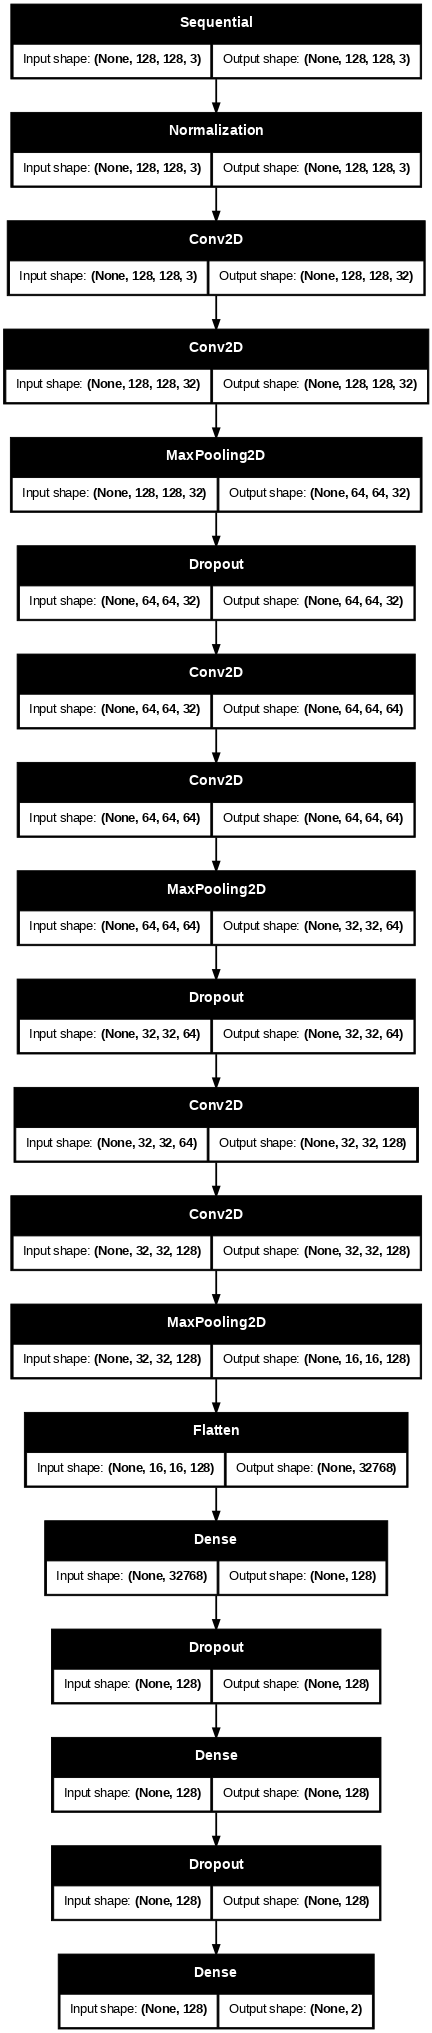

In [46]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=65)

### 2.6 Model Training with sklearn

We get the same results when using sklearn, this is expected.

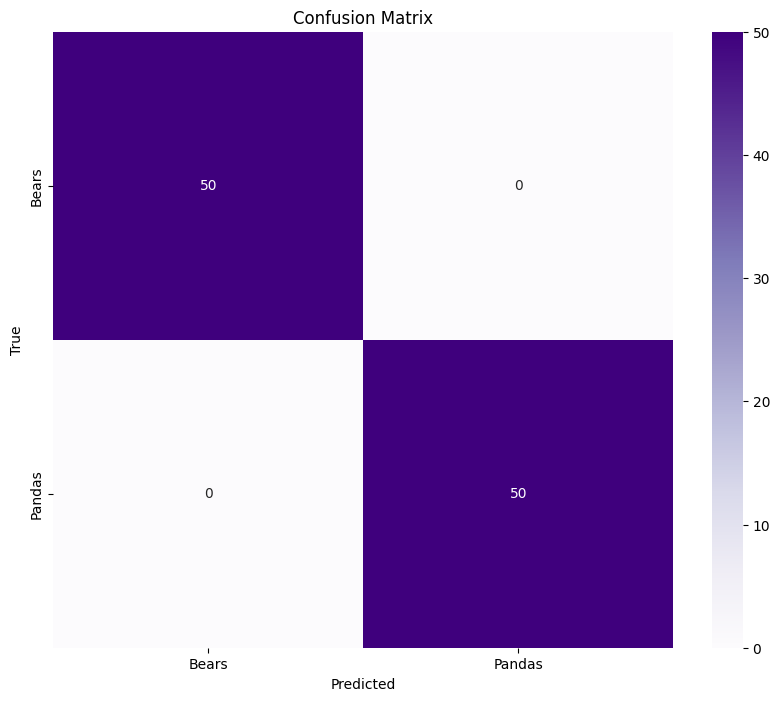


Confusion Matrix:
[[50  0]
 [ 0 50]]
              precision    recall  f1-score   support

       Bears       1.00      1.00      1.00        50
      Pandas       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

# For training data
X_train = []
y_train = []
for images, labels in train:
  X_train.extend(images.numpy())
  y_train.extend(labels.numpy())
X_train = np.array(X_train)
y_train = np.array(y_train)

# For testing data
X_test = []
y_test = []
for images, labels in test:
  X_test.extend(images.numpy())
  y_test.extend(labels.numpy())
X_test = np.array(X_test)
y_test = np.array(y_test)

# Reshape X_train and X_test
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten each image
X_test = X_test.reshape(X_test.shape[0], -1)

# Fit model
model = SVC(kernel='linear', C=1)  # Choose a kernel and regularization parameter
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nConfusion Matrix:")
print(cm)

# Print evalutation metrics
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, target_names=class_names)
print(report)


### Exporting to a pdf (not part of final)

In [48]:
!pip install nbconvert

In [49]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern fonts-noto-mono fonts-texgyre
  fonts-urw-base35 libapache-pom-java libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3
  libcommons-logging-java libcommons-parent-java libfontbox-java libfontenc1 libgs9 libgs9-common
  libidn12 libijs-0.35 libjbig2dec0 libkpathsea6 libpdfbox-java libptexenc1 libruby3.0 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libwoff1 libzzip-0-13 lmodern pandoc-data poppler-data
  preview-latex-style rake ruby ruby-net-telnet ruby-rubygems ruby-webrick ruby-xmlrpc ruby3.0
  rubygems-integration t1utils teckit tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-latex-recommended texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-fre

In [52]:
!jupyter nbconvert --to pdf --output /content/ModelSelectionAndTraining.pdf /content/ModelSelectionAndTraining.ipynb

[NbConvertApp] Converting notebook /content/ModelSelectionAndTraining.ipynb to pdf
[WARNING] Could not parse YAML metadata at line 12 column 1: not an object
[NbConvertApp] Support files will be in /content/ModelSelectionAndTraining_files/
[NbConvertApp] Writing 124680 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 2691266 bytes to /content/ModelSelectionAndTraining.pdf
